# Fake News

**The evolution of the information and communication technologies has dramatically increased the number of people with access to the Internet, which has changed the way the information is consumed. As a consequence of the above, fake news have become one of the major concerns because its potential to destabilize governments, which makes them a potential danger to modern society. An example of this can be found in the US. electoral campaign, where the term "fake news" gained great notoriety due to the influence of the hoaxes in the final result of these.**

<img src="https://ichef.bbci.co.uk/news/904/cpsprodpb/15B3B/production/_99919888_fakenews4.gif"/>

# Importing Library

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.layers import Dropout

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [14]:
from tqdm import tqdm

# Reading Dataset

In [15]:
train_df = pd.read_csv('../data/raw/train.csv')

In [16]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Total number of messages

In [18]:
np.max(train_df.id)

20799

# Data Preprocessing

1. Putting features to 'X' and Target/Label to 'Y'
2. From the gained text except the alphabet (A-Z, a-z).. all others are removed
3. Gained Text is Lowered and StopWords is removed

**After all this operation below operation is done.(Generalized Version may change little in different project)**
<img src="https://raw.githubusercontent.com/milan400/kaggle/master/lstm%20data%20preprocessing.png"/>

In [19]:
# Drop Nan Values
X = train_df.dropna()

# Get training data
X = train_df.drop('label', axis = 1)

#  Get target label
y = train_df['label']

# OneHot Representation

In [20]:
messages = X.copy()

In [21]:
messages.reset_index(inplace = True)

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BAOVIET\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Dataset Preprocessing
ps = PorterStemmer()

corpus = []

for i in tqdm(range(0, len(messages))):
    # replace with space words other than a-1, A-Z
    
    review = re.sub('[^a-zA-Z]', ' ', str(messages['title'][i]))
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

100%|██████████| 20800/20800 [01:02<00:00, 334.04it/s]


In [24]:
# vocabulray size
voc_size = 5000

In [25]:
onehot_repr = [one_hot(words, voc_size) for words in corpus]
normal_repr = [(words, voc_size) for words in corpus]

In [26]:
print("Normal Representation:",normal_repr[0][0])
print("One Hot Representation:",onehot_repr[0])

Normal Representation: hous dem aid even see comey letter jason chaffetz tweet
One Hot Representation: [3379, 938, 9, 4031, 2711, 2889, 612, 308, 678, 39]


# Embedding Representation

# Constructing Transformer model

# Setup

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Implement multi head self attention as a keras layer

In [28]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads !=0:
             raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b = True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights
    
    def seperate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.seperate_heads(query, batch_size)
        key = self.seperate_heads(key, batch_size)
        value = self.seperate_heads(value, batch_size)
        
        attention, weights = self.attention(query, key, value)
        
        attention = tf.transpose(attention, perm=[0,2,1,3])
        
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
        output = self.combine_heads(concat_attention)
        
        return output

# Implement a Transformer block as a layer

In [29]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training = training)
        
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        
        fnn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

# Implement Embedding Layer
* Two seperate embedding layers, one for tokens, one for token index (positions).

In [30]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)
        self.pos_emb = layers.Embedding(input_dim = maxlen, output_dim = embed_dim)
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        x = self.token_emb(x)
        
        return x + positions

# Create Classifier model using Transfomer layer

* Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text



In [31]:
# making all sentences of same length
maxlen = 20

# vocabulray size
vocab_size = 5000

embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = maxlen)#

In [32]:
print("One Hot Representation:",onehot_repr[0])
print("Padding:",embedded_docs[0])

One Hot Representation: [3379, 938, 9, 4031, 2711, 2889, 612, 308, 678, 39]
Padding: [   0    0    0    0    0    0    0    0    0    0 3379  938    9 4031
 2711 2889  612  308  678   39]


In [33]:
embed_dim = 40
num_heads = 4
ff_dim = 32

inputs = layers.Input(shape = (maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddi  (None, 20, 40)            200800    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 20, 40)            9352      
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 40)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 40)                0     

# Model Visualization

In [35]:
# from tensorflow.keras.utils.vis_utils import plot_model

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

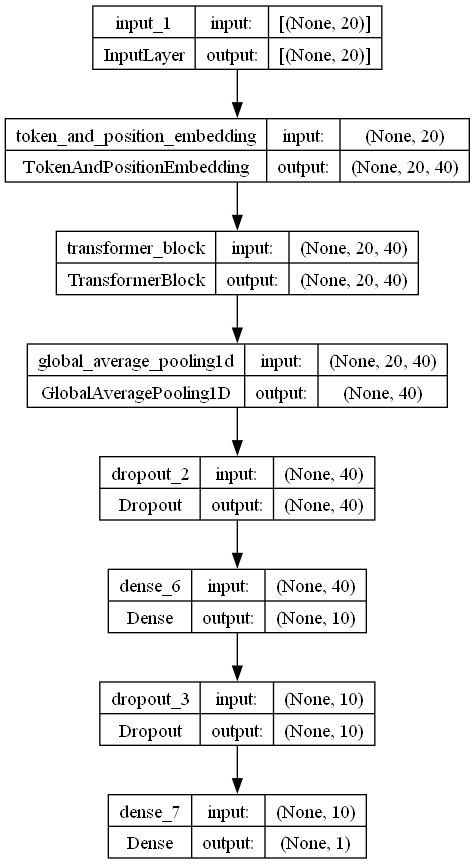

In [36]:
import pydot
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [37]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

**Splitting Data into train and test**

In [38]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Model Training

In [40]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
520/520 [==============================] - 4s 5ms/step - loss: 0.2735 - accuracy: 0.8867 - val_loss: 0.1954 - val_accuracy: 0.9219
Epoch 2/10
520/520 [==============================] - 2s 5ms/step - loss: 0.1403 - accuracy: 0.9493 - val_loss: 0.1972 - val_accuracy: 0.9185
Epoch 3/10
520/520 [==============================] - 2s 4ms/step - loss: 0.1056 - accuracy: 0.9616 - val_loss: 0.2864 - val_accuracy: 0.9200
Epoch 4/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0873 - accuracy: 0.9677 - val_loss: 0.2630 - val_accuracy: 0.9192
Epoch 5/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0667 - accuracy: 0.9750 - val_loss: 0.3587 - val_accuracy: 0.9151
Epoch 6/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0546 - accuracy: 0.9794 - val_loss: 0.3432 - val_accuracy: 0.9125
Epoch 7/10
520/520 [==============================] - 2s 4ms/step - loss: 0.0435 - accuracy: 0.9842 - val_loss: 0.4592 - val_accuracy: 0.9137
Epoch 

# Visualizing Train,Test--->Accuracy,Loss

In [41]:
model.history.history

{'loss': [0.2734692096710205,
  0.14030493795871735,
  0.10559097677469254,
  0.08732371777296066,
  0.06672964990139008,
  0.054614000022411346,
  0.04347601160407066,
  0.03368512913584709,
  0.02523978240787983,
  0.01821800321340561],
 'accuracy': [0.8866586685180664,
  0.9492788314819336,
  0.9615985751152039,
  0.9677283763885498,
  0.9750000238418579,
  0.9793870449066162,
  0.9841946959495544,
  0.9879207015037537,
  0.9918269515037537,
  0.9948918223381042],
 'val_loss': [0.19536475837230682,
  0.19723200798034668,
  0.2864099144935608,
  0.26300927996635437,
  0.35870784521102905,
  0.3432103395462036,
  0.45924288034439087,
  0.4510774612426758,
  0.5429848432540894,
  0.5646129250526428],
 'val_accuracy': [0.921875,
  0.9185096025466919,
  0.9199519157409668,
  0.9192307591438293,
  0.9151442050933838,
  0.9125000238418579,
  0.9137019515037537,
  0.9084134697914124,
  0.9122596383094788,
  0.9081730842590332]}

<Figure size 640x480 with 0 Axes>

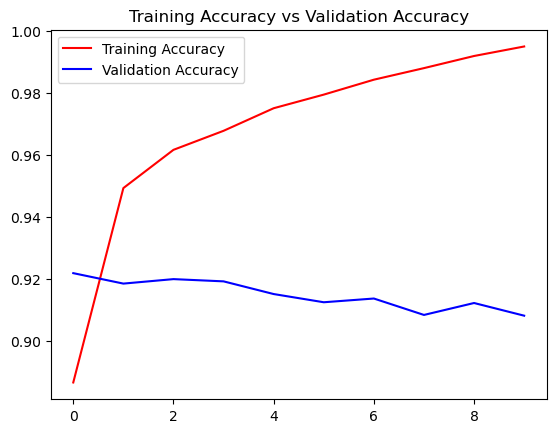

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

# visualizing losses and accuracy
%matplotlib inline

train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_acc,'r', label='Training Accuracy')
plt.plot(epochs,val_acc,'b', label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()
plt.figure()

# Reading and Preprocessing Test data

In [43]:
def return_x_y(X):
    
    # Drop Nan Values
    X = X.fillna(0)
    
    messages = X.copy()

    messages.reset_index(inplace = True)

    # Dataset Preprocessing
    ps = PorterStemmer()

    corpus = []

    for i in range(0, len(messages)):
        # replace with space words other than a-1, A-Z

        review = re.sub('[^a-zA-Z]', ' ', str(messages['title'][i]))
        review = review.lower()
        review = review.split()

        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)

    # vocabulray size
    voc_size = 5000

    onehot_repr = [one_hot(words, voc_size) for words in corpus]

    # Embedding Representation
    # making all sentences of same length
    sent_length = 20
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)

    X_final = np.array(embedded_docs)
    
    
    return X_final, X

In [44]:
test_df = pd.read_csv('../data/raw/test.csv')
X_test,X_test_drop = return_x_y(test_df)

In [45]:
print(X_test)

[[   0    0    0 ... 2660 2116 4989]
 [   0    0    0 ...  108 4456 2919]
 [   0    0    0 ...  834 4413  619]
 ...
 [   0    0    0 ... 2660 2116 4989]
 [   0    0    0 ...  418 3687 1949]
 [   0    0    0 ... 2660 2116 4989]]


In [46]:
print(X_test_drop)

         id                                              title  \
0     20800  Specter of Trump Loosens Tongues, if Not Purse...   
1     20801  Russian warships ready to strike terrorists ne...   
2     20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3     20803  Tim Tebow Will Attempt Another Comeback, This ...   
4     20804                    Keiser Report: Meme Wars (E995)   
...     ...                                                ...   
5195  25995  The Bangladeshi Traffic Jam That Never Ends - ...   
5196  25996  John Kasich Signs One Abortion Bill in Ohio bu...   
5197  25997  California Today: What, Exactly, Is in Your Su...   
5198  25998  300 US Marines To Be Deployed To Russian Borde...   
5199  25999  Awkward Sex, Onscreen and Off - The New York T...   

                       author  \
0            David Streitfeld   
1                           0   
2               Common Dreams   
3               Daniel Victor   
4     Truth Broadcast Network   
...      

In [47]:
y_pred_test = model.predict(X_test)

163/163 [==============================] - 1s 2ms/step


# Submission data

In [48]:
submission_data = pd.read_csv('data/predict/submit.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/predict/submit.csv'

In [ ]:
len(X_test_drop['id']), len(y_pred_test)

(5200, 5200)

In [ ]:
df_sub = pd.DataFrame()
df_sub['id'] = X_test_drop['id']
df_sub['label'] = y_pred_test

In [ ]:
# Converting float to Integer
df_sub['label'] = df_sub['label'].apply(lambda x:0 if x<=0.5 else 1)

In [ ]:
# df_sub.to_csv('gender_submission.csv', index=False)

In [ ]:
save_model(model,"w.h5")

C:\Users\BAOVIET\AppData\Local\Temp\ipykernel_25384\4020261164.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,"w.h5")
